<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/langchain/langgraph/Langgraph_multi_modal_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Langgraph multi modal Agent

### Tools
Tools are external resources, services, or APIs that an LLM agent can access and utilize to expand its capabilities and perform specific tasks. These supplementary components allow the agent to go beyond its core language processing abilities, enabling it to interact with external systems, retrieve information, or execute actions that would otherwise be outside its scope. By integrating tools, LLM agents can provide more comprehensive and practical solutions to user queries and commands.

A tool consists of:

- The name of the tool.
- A description of what the tool does.
- A JSON schema defining the inputs to the tool.
- A function (and, optionally, an async variant of the function)

When a tool is bound to a model, the name, description and JSON schema are provided as context to the model. Given a list of tools and a set of instructions, a model can request to call one or more tools with specific inputs.

https://python.langchain.com/v0.2/docs/concepts/#tools


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic langchain_openai langchain-google-genai langchain-community  langchain-chroma  pandas  ipywidgets pillow

In [2]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "lg-multimodal-agent"
os.environ["OPENAI_API_KEY"] =  userdata.get("KEY_OPENAI")
os.environ["ANTHROPIC_API_KEY"]=  userdata.get("ANTROPIC_KEY")
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [3]:
import pandas as pd
from collections import Counter
from langchain_core.tools import tool


def read_travel_data(file_path: str = "/content/drive/MyDrive/data/synthetic_travel_data.csv") -> pd.DataFrame:
    """Read travel data from CSV file"""
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        return pd.DataFrame(
            columns=[
                "Name",
                "Current_Location",
                "Age",
                "Past_Travel_Destinations",
                "Number_of_Trips",
                "Flight_Number",
                "Departure_City",
                "Arrival_City",
                "Flight_Date",
            ]
        )


@tool
def compare_and_recommend_destination(name: str) -> str:
    """This tool is used to check which destinations user has already traveled.
    Use name of the user to fetch the information about that user.
    If user has already been to a city then do not recommend that city.

    Args:
        name (str): Name of the user.
    Returns:
        str: Destination to be recommended.

    """

    df = read_travel_data()

    if name not in df["Name"].values:
        return "User not found in the travel database."

    user_data = df[df["Name"] == name].iloc[0]
    current_location = user_data["Current_Location"]
    age = user_data["Age"]
    past_destinations = user_data["Past_Travel_Destinations"].split(", ")

    # Get all past destinations of users with similar age (±5 years) and same current location
    similar_users = df[
        (df["Current_Location"] == current_location)
        & (df["Age"].between(age - 5, age + 5))
    ]
    all_destinations = [
        dest
        for user_dests in similar_users["Past_Travel_Destinations"].str.split(", ")
        for dest in user_dests
    ]

    # Count occurrences of each destination
    destination_counts = Counter(all_destinations)

    # Remove user's current location and past destinations from recommendations
    for dest in [current_location] + past_destinations:
        if dest in destination_counts:
            del destination_counts[dest]

    if not destination_counts:
        return f"No new recommendations found for users in {current_location} with similar age."

    # Get the most common destination
    recommended_destination = destination_counts.most_common(1)[0][0]

    return f"Based on your current location ({current_location}), age ({age}), and past travel data, we recommend visiting {recommended_destination}."

In [4]:
df = read_travel_data()
df

,Name,Current_Location,Age,Past_Travel_Destinations,Number_of_Trips,Flight_Number,Departure_City,Arrival_City,Flight_Date
0,Stephen Walker,Honolulu,20.0,"Orlando, Miami, Phoenix, Chicago",4.0,T6387,Honolulu,Orlando,2024-05-19
1,NaN,NaN,NaN,NaN,NaN,B8212,Honolulu,Miami,2023-05-02
2,NaN,NaN,NaN,NaN,NaN,I7809,Honolulu,Phoenix,2024-02-20
3,NaN,NaN,NaN,NaN,NaN,U3713,Honolulu,Chicago,2022-09-04
4,Colton Fisher,Richmond,64.0,"San Diego, Houston",2.0,K7844,Richmond,San Diego,2022-11-24
...,...,...,...,...,...,...,...,...,...
1490,Christian Morales,Venice,48.0,Bergen,1.0,O5870,Venice,Bergen,2024-06-07
1491,Julie Kim,Nice,39.0,"Tallinn, Madrid, Copenhagen, Seville",4.0,E3969,Nice,Tallinn,2023-07-25
1492,NaN,NaN,NaN,NaN,NaN,M2535,Nice,Madrid,2024-08-14
1493,NaN,NaN,NaN,NaN,NaN,Q3275,Nice,Copenhagen,2023-06-21


In [5]:
df[df.Name=="Christian Morales"]

,Name,Current_Location,Age,Past_Travel_Destinations,Number_of_Trips,Flight_Number,Departure_City,Arrival_City,Flight_Date
1490,Christian Morales,Venice,48.0,Bergen,1.0,O5870,Venice,Bergen,2024-06-07


In [25]:
df[df['Current_Location']== "Venice"]

,Name,Current_Location,Age,Past_Travel_Destinations,Number_of_Trips,Flight_Number,Departure_City,Arrival_City,Flight_Date
49,Marc Alexander,Venice,19.0,"Warsaw, Brussels, Oslo, St. Petersburg",4.0,G2409,Venice,Warsaw,2022-10-02
60,Melissa Schmidt,Venice,33.0,Luxembourg,1.0,N7151,Venice,Luxembourg,2024-08-12
117,Chelsea Larson,Venice,62.0,"Copenhagen, Stockholm, Berlin",3.0,K8609,Venice,Copenhagen,2023-05-26
132,Kevin Garcia,Venice,38.0,"Marseille, Bergen, Lyon",3.0,I1055,Venice,Marseille,2024-05-30
1010,Karen Paul,Venice,29.0,"Seville, Munich, Moscow, Luxembourg, Naples",5.0,S4822,Venice,Seville,2024-03-17
1039,Justin Jones,Venice,37.0,"Berlin, Paris, Paris, Bordeaux",4.0,Q3141,Venice,Berlin,2023-02-04
1326,Cody Hunter,Venice,71.0,Amsterdam,1.0,F5660,Venice,Amsterdam,2023-02-18
1422,Roger Gonzalez,Venice,30.0,"Istanbul, Seville, Oslo, Istanbul",4.0,I1649,Venice,Istanbul,2022-09-21
1490,Christian Morales,Venice,48.0,Bergen,1.0,O5870,Venice,Bergen,2024-06-07


In [26]:
compare_and_recommend_destination("Kevin Garcia")

'Based on your current location (Venice), age (38.0), and past travel data, we recommend visiting Paris.'

In [27]:
from langchain_google_genai import ChatGoogleGenerativeAI
# Set up the model
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatOpenAI(model="gpt-4o")

In [30]:
tools = [compare_and_recommend_destination]

In [31]:
llm_with_tools = llm.bind_tools(tools)

In [32]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolInvocation

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]



In [33]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, MessagesState, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    """Always use tools to fulfill user requests.
    1. If you do not have enough inputs to execute a tool then you can ask for more information.
    2. If user has uploaded image and 'image_processing_node' has returned city and activity then use that information to call 'chatbot'
    """
    # Filter out messages with image type
    # text_messages = [msg for msg in state["messages"] if msg['content'][0].get("type") != "image"]
    text_messages = [
        msg for msg in state["messages"]
        if not (isinstance(msg.content, list) and msg.content[0].get("type") == "image_url")
    ]

    # Invoke LLM with only text messages
    return {"messages": [llm_with_tools.invoke(text_messages)]}


graph_builder.add_node("chatbot", chatbot)

In [34]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", "__end__": "__end__"},
)

In [35]:
def process_image_input(state):
    """
    Process image input. This tool will return activity shown in this image.
    """
    last_message = state["messages"][-1].content[0]
    input_image = last_message['image_url']['url']
    print(input_image)
    message = HumanMessage(
        content=[
            {"type": "text", "text": "Which activity is shown in this image?"},
            {
                "type": "image_url",
                # "image_url": {"url": {input_image}},
                "image_url": {"url": f"data:image/jpeg;base64,{input_image}"},
            },
        ],
    )
    response = llm.invoke([message])
    print(response.content)
    output = {
        "messages": [
            HumanMessage(
                content=f"Image information: {response.content}", name="image_description"
            )
        ],
    }
    return output

In [36]:
graph_builder.add_node("image_processing_node", process_image_input)

In [37]:
def is_image_node(state):
    messages = state["messages"]
    last_message = messages[-1]
    if hasattr(last_message, "content") and isinstance(last_message.content, list):
        for item in last_message.content:
            if isinstance(item, dict) and item.get("type") == "image_url":
                return True
    return False

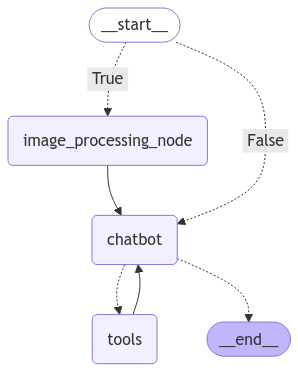

In [38]:
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

memory = MemorySaver()

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("image_processing_node", "chatbot")
graph_builder.add_conditional_edges(START, is_image_node, {True: "image_processing_node", False:"chatbot"})

graph = graph_builder.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [39]:
from IPython.display import display, clear_output
import ipywidgets as widgets

from PIL import Image
import io
import base64




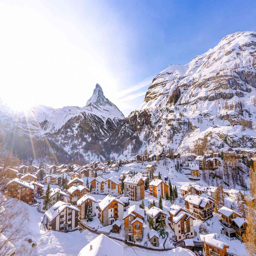

In [40]:
img = Image.open("/content/drive/MyDrive/data/images/images/zermatt.jpg")
img.resize((256, 256))

In [41]:
buffered = io.BytesIO()
img.save(buffered, format=img.format)
img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")

In [42]:
from langchain_core.messages import HumanMessage
import pprint
config = {"configurable": {"thread_id": "20"}}
message = HumanMessage(
    content=[
        {
            "type": "image_url",
            "image_url": {"url": img_str},
        },
    ],
)
pprint.pprint(graph.invoke({"messages": message}, config)["messages"][-1].content)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAPoBdwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3qin0VVwGUU+mUAFFFFMAooooAKKKKACiiigAooooAKKKKACiiigAop9MpAFFFFMAooooAKKKKACiiigAqOpKKAI6KkqOgAooopgFMp9FBAyin0yqAKKKKACiiigAooooAKKKKACo6kooAjooooASm06iqGNoooqhDKKfRQAy

In [43]:
pprint.pprint(
    graph.invoke(
        {
            "messages": [
                (
                    "user",
                    "My name is Kevin Garcia",
                )
            ]
        },
        config,
    )["messages"][-1].content
)

('Based on your travel history and preferences, I recommend visiting Paris. It '
 'offers a wide range of cultural experiences, beautiful architecture, and '
 'wonderful cuisine. Enjoy your trip! If you have any specific activities or '
 'interests in mind, feel free to ask for more tailored recommendations.')


In [44]:
pprint.pprint(
    graph.invoke(
        {
            "messages": [
                (
                    "user",
                    "yes I want some suggestions based on the picture",
                )
            ]
        },
        config,
    )["messages"][-1].content
)

('The image depicts a snowy mountain village, which is often associated with '
 'winter sports like skiing and snowboarding. Here are some popular '
 'destinations known for such activities:\n'
 '\n'
 '1. **Zermatt, Switzerland**: Known for the iconic Matterhorn, Zermatt offers '
 'world-class skiing and a charming alpine village atmosphere.\n'
 '\n'
 '2. **Aspen, Colorado, USA**: A famous ski resort known for its excellent '
 'slopes and vibrant après-ski scene.\n'
 '\n'
 '3. **Chamonix, France**: Nestled in the French Alps, Chamonix is renowned '
 'for its skiing and breathtaking mountain views.\n'
 '\n'
 '4. **Whistler, Canada**: Home to one of the largest ski resorts in North '
 'America, Whistler offers a wide range of winter sports and activities.\n'
 '\n'
 '5. **Niseko, Japan**: Famous for its light powder snow, Niseko is a top '
 'destination for skiing and snowboarding enthusiasts.\n'
 '\n'
 'If any of these destinations interest you, I can provide more information or '
 'help

In [45]:
pprint.pprint(
    graph.invoke(
        {
            "messages": [
                (
                    "user",
                    "yes I want only destinations in Europe ",
                )
            ]
        },
        config,
    )["messages"][-1].content
)

('Sure! Here are some top snowy mountain destinations in Europe, perfect for '
 'winter sports and scenic views:\n'
 '\n'
 '1. **Zermatt, Switzerland**: Known for its iconic Matterhorn, Zermatt offers '
 'excellent skiing opportunities and a charming alpine village.\n'
 '\n'
 '2. **Chamonix, France**: Located in the French Alps, Chamonix is a popular '
 'destination for skiing and offers stunning mountain scenery.\n'
 '\n'
 '3. **St. Anton, Austria**: Known for its lively après-ski scene and '
 'extensive ski area, St. Anton is a favorite among ski enthusiasts.\n'
 '\n'
 "4. **Cortina d'Ampezzo, Italy**: A picturesque resort in the Dolomites, "
 'offering a mix of skiing and Italian charm.\n'
 '\n'
 "5. **Val d'Isère, France**: Part of the Espace Killy ski area, Val d'Isère "
 'is renowned for its challenging slopes and vibrant village life.\n'
 '\n'
 '6. **Kitzbühel, Austria**: Famous for its annual Hahnenkamm ski race, '
 'Kitzbühel combines traditional Tyrolean charm with modern ski